In [248]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats

In [368]:
raw_data=[]
with open('MMSE.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        raw_data.append(row[2])
raw_data.pop(0)

'MMSE Total Score'

In [455]:
dataset = []
for item in raw_data:
    dataset.append(float(item))
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [456]:
#24 month
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
data_X, data_Y = create_dataset(dataset)
train_size = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]
train_X = train_X.reshape(-1, 1, 3) #need modify last dim to 'look_back'
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 3) #need modify last dim tp 'look_back'

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [416]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x) 
        s, b, h = x.shape
        x = x.view(s*b, h) 
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    

In [451]:
def train(train_x, train_y, model, optimizer, criterion):
    model.train()
    Loss=[]
    for e in range(20000):
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        var_x, var_y  = Variable(train_x), Variable(train_y)
        var_x, var_y  = var_x.float(), var_y.float()
        out = model(var_x)
        loss = criterion(out, var_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (e + 1) % 10000 == 0: 
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
            Loss.append(loss.item())
    return Loss

def test(test_x, model):
    model = model.eval()
    test_x = test_x.to(DEVICE)
    var_data = Variable(test_x)
    var_data = var_data.float()
    pred_test = model(var_data)
    pred_test = pred_test.cpu()
    pred_test = pred_test.view(-1).data.numpy()
    return pred_test

In [452]:
DEVICE = 'cuda:0' 
model = lstm_reg(3, 5).to(DEVICE)
#model.load_state_dict(torch.load('long_24m.pth'))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = train(train_x, train_y, model, optimizer, criterion)

Epoch: 10000, Loss: 0.01760
Epoch: 20000, Loss: 0.01519


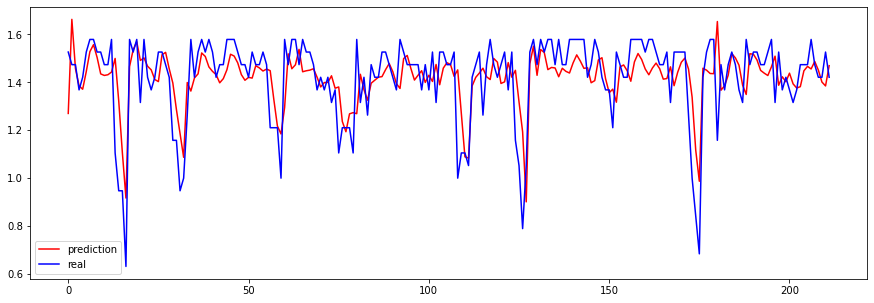

In [453]:
#model = lstm_reg(3, 5).to(DEVICE)
#model.load_state_dict(torch.load('long_24m.pth'))
output = test(test_x, model)
plt.plot(output, 'r', label='prediction')
plt.plot(test_Y, 'b', label='real')
plt.legend(loc='best')

In [454]:
print(stats.ttest_rel(output, test_Y))
data = pd.DataFrame({'output':output, 'test':test_Y})
data.corr()

Ttest_relResult(statistic=-0.37719572382697, pvalue=0.7064072551146272)


,output,test
output,1.000000,0.692357
test,0.692357,1.000000


In [438]:
name = 'long_24m.pth'
torch.save(model.state_dict(), name)

In [462]:
from torchvision.models import resnet50 
from thop import profile
model = lstm_reg(3, 5).to(DEVICE)
input=torch.randn(846,1,3).to(DEVICE)
macs, params = profile(model, inputs=(input, ), verbose=False)
print(f"macs = {macs/1e9}G")
print(f"params = {params/1e6}M")

macs = 0.00044415G
params = 0.000446M
